# Notebook 01: MRCP Feature Extraction.
Extract movement-related cortical potential (MRCP) features from single-trial EEG data using the bci-core library. This includes computing `area under the curve (AUC)`, `peak amplitud`, and `slope` for each EEG channel per trial.
#### Rational:
- MRCPs are low-frequency deflections preceding movement onset and are useful for intent detection in BCIs.
- Extracting interpretable features (like negative peak or slope) enables early SVM-based classifiers without Deep Learning.
- Motor intent correlates with activity in SMC (sensorimotor cortex) and PFC (prefrontal cortex). MRCPs provide EEG evidence of such intent.
- This forms the baseline for training classifiers in Stage 2, tested locally then deployed via CI/CD pipeline.

### Cell 1. Notebook Header, Imports, and Configuration.
Initialise the notebook with title, dependencies, and reproducibility settings. This prepares the environment for MRCP feature extraction.
#### Rationale:
- Ensures clear scientific naming and proper structure for publication or future CI/CD automation.
- Guarantees version-locking and reproducibility (essential for regulatory and academic contexts).
- Loads the necessary `bci_core` components for preprocessing and feature extraction.

In [1]:
# ============================================================
# Cell 1. Notebook Header, Imports, and Configuration.
# ============================================================

# -- System & I/O --
import os
import numpy as np
import matplotlib.pyplot as plt

# -- Signal Processing --
from bci_core.preprocessor import SignalPreprocessor
from bci_core.mrcp_feature_extractor import MRCPFeatureExtractor

# -- Reproducibility --
np.random.seed(42)

# -- Display Settings --
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['font.size'] = 12

# -- Path Setup --
DATA_DIR = '/lab/px/anichlabs/bci-tools/data/'
RAW_PATH = os.path.join(DATA_DIR, 'raw')
PRE_PATH = os.path.join(DATA_DIR, 'clean')
FEAT_PATH = os.path.join(DATA_DIR, 'feat')

# -- Create dirs if missing --
for path in [RAW_PATH, PRE_PATH, FEAT_PATH]:
    os.makedirs(path, exist_ok=True)

print('Notebook ready. Dependencies and folders are set.')

'''
`bci_core`is a local editable Python package, not published on PyPI.
It must be installed in editable mode so the Jupyter kernel knows how to
find it during imports. This is essential for proper `import` resolution
in notebooks and tests.
Before importing the package from the project directory `src/bci_core`,
run the next commands in the root (in case of using conda environments):
`conda activate bci`
`pip install -e .`
'''

Notebook ready. Dependencies and folders are set.


'\n`bci_core`is a local editable Python package, not published on PyPI.\nIt must be installed in editable mode so the Jupyter kernel knows how to\nfind it during imports. This is essential for proper `import` resolution\nin notebooks and tests.\nBefore importing the package from the project directory `src/bci_core`,\nrun the next commands in the root (in case of using conda environments):\n`conda activate bci`\n`pip install -e .`\n'

### Cell 2. Load Simulated EEG Trial.
Simulate a 4-channel EEG trial (4 seconds at 250 Hz) with Gaussian noise. This emulates real EEG input to test MRCP feature extraction without hardware.
#### Rationale:
- Allows testing without connecting the BCI board.
- Matches expectect BCI sampling rate and trial length.
- Enables full development and unit testing of MRCP algorithms using synthetic data.

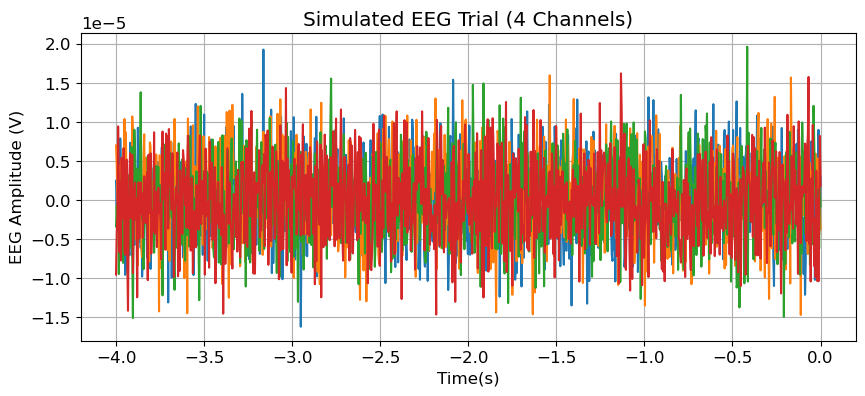

In [2]:
# ===============================================
# Simulate a 4-channel EEG trial (baseline test)
# ===============================================

# -- EEG trial settings --
n_channels = 4
sfreq = 250        # Sampling frequency in Hz.
duration = 4.0     # Trial duration in seconds.
n_samples = int(sfreq * duration)

# -- Generate random EEG signal --
# The amplitude of MRCP (movement preparation) is ~-5 to -20 µV. 
eeg_trial = np.random.randn(n_channels, n_samples) * 5e-6 # Simulated microvolt-level noise.

# -- Time axis: from -4.0 to 0.0 seconds (0.0 = movement onset) --
t = np.linspace(-duration, 0, n_samples)

# -- Plot example --
plt.plot(t, eeg_trial.T)
plt.xlabel('Time(s)')
plt.ylabel('EEG Amplitude (V)')
plt.title('Simulated EEG Trial (4 Channels)')
plt.grid(True)
plt.show()

### Cell 3. Extract MRCP Features (Area, Peak, Slope).
Use the MRCPFeatureExtractor to compute MRCP features for each channel:
- Area under the curve (AUC) from -1.5s to 0.0 s.
- Peak amplitud (most negative deflection).
- Slope of the rising deflection before movement onset.
#### Rationale:
- These features are biologically interpretable markers of movement preparation.
- They can feed a simple classifier like SVM in early BCI prototypes.
- It is possible to validate the full feature extraction pipeline without relying on real EEG yet.

In [3]:
# ============================================
# Extract MRCP features from the EEG trial
# ============================================

# -- Initialise the extractor --
extractor = MRCPFeatureExtractor(sfreq=sfreq)

# -- Compute all MRCP features: area, peak, slope --
features = extractor.extract_all(eeg_trial)

# -- Display --
print('Extracted MRCP Features (per channel):\n')
for ch_idx, ch_feats in features.items():
    print(f'Channel {ch_idx}:')
    for feat_name, feat_value in ch_feats.items():
        print(f'  {feat_name:<6} = {feat_value:.2e}')
    print()

Extracted MRCP Features (per channel):

Channel 0:
  area   = -3.40e-07
  peak   = -1.35e-05
  slope  = -1.16e-06

Channel 1:
  area   = -4.64e-07
  peak   = -1.47e-05
  slope  = 1.48e-06

Channel 2:
  area   = -1.44e-07
  peak   = -1.50e-05
  slope  = 3.14e-07

Channel 3:
  area   = 3.76e-07
  peak   = -1.20e-05
  slope  = -1.48e-07



### Cell 4. Save MRCP Features to CSV.
Save extracted features to a structured CSV file under `/lab/px/bci-tools/data/features/mrcp_features_trial01.csv`.
#### Rationale:
- Standard CSV format eases integration with classifiers (e.g. SVM, XGBoost).
- Enables reproducibility and comparison across trials.
- Essential for building datasets incrementally, trial-by-trial.


In [4]:
# ============================================
# Save MRCP features to CSV (1 row per channel)
# ============================================

import pandas as pd

# Convert dict-of-dicts to DataFrame.
df_feats = pd.DataFrame.from_dict(features, orient='index')
df_feats.index.name = 'channel'

# Define output path.
out_path = os.path.join(FEAT_PATH, 'mrcp_features_trial01.csv')

# Save to CSV.
df_feats.to_csv(out_path, index=True)

print(f'MRCP features saved to:\n{out_path}')
df_feats.head()

MRCP features saved to:
/lab/px/anichlabs/bci-tools/data/feat/mrcp_features_trial01.csv


,area,peak,slope
channel,,,
0,-3.402171e-07,-0.000013,-1.159346e-06
1,-4.640827e-07,-0.000015,1.477288e-06
2,-1.435199e-07,-0.000015,3.138979e-07
3,3.758042e-07,-0.000012,-1.479851e-07


### Cell 5. Simulate & Extract  Multiple Trials.
Simulate 20 EEG trials, extract MRCP features for each channel in each trial, and compile the results into a DataFrame. 
Save the results as a CSV file.
#### Rationale:
- Provides synthetic training data for ML classifiers before real BCI trials.
- Validates stability of feature extraction logic across multiple inputs.
- Essential for testing classifiers like SVM (Support Vector Machine), XGBoost (Extreme Gradient Boosting), or LDA (Linear Discriminant Analysis) with structured input.

In [5]:
# ================================================
# Cell 5. Simulate and extract from multiple trials
# ================================================

n_trials = 20    # Number of stimulated trials.
trial_data = []  # List to hold all feature rows.

for trial_id in range(n_trials):
    # -- Simulate EEG trial --
    eeg_trial = np.random.randn(n_channels, n_samples) * 5e-6

    # -- Extract features --
    feats = extractor.extract_all(eeg_trial)

    # -- Flatten to row: each row = 1 channel in 1 trial --
    for ch_idx, ch_feats in feats.items():
        row = {
            'trial': trial_id,
            'channel': ch_idx,
            **ch_feats # area, peak, slope
        }
        trial_data.append(row)

# -- Convert to DataFrame --
df_batch = pd.DataFrame(trial_data)

# -- Save to CSV --
out_batch_path = os.path.join(FEAT_PATH, 'mrcp_features_batch.csv')
df_batch.to_csv(out_batch_path, index=False)

print(f'Multi-trial MRCP dataset saved to:\n{out_batch_path}')
df_batch.head()

Multi-trial MRCP dataset saved to:
/lab/px/anichlabs/bci-tools/data/feat/mrcp_features_batch.csv


,trial,channel,area,peak,slope
0,0,0,1.425662e-07,-0.000016,3.062284e-06
1,0,1,6.197680e-07,-0.000014,-3.961403e-06
2,0,2,3.670137e-07,-0.000014,-9.831746e-07
3,0,3,-5.901153e-07,-0.000018,1.781510e-07
4,1,0,-2.268270e-07,-0.000011,-5.137295e-06


### Cell 6. Visualise MRCP Feature Distributions.
Plot the distributions of `area`, `peak`, and `slope` across all channels and trials using histograms and boxplots.
#### Rationale:
- Helps detect outliers, skewness, or feature scaling issues.
- Enables early insight into variability across EEG channels.
- Critical for guiding preprocessing and feature selection in classification tasks.

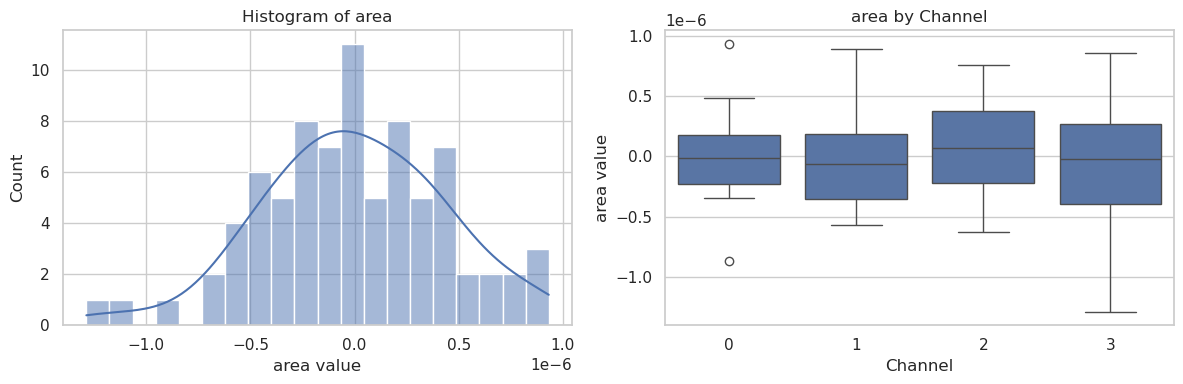

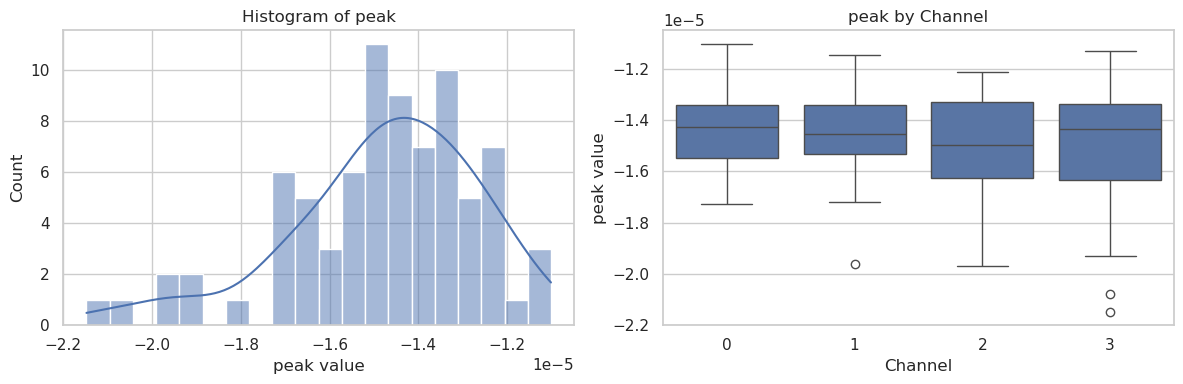

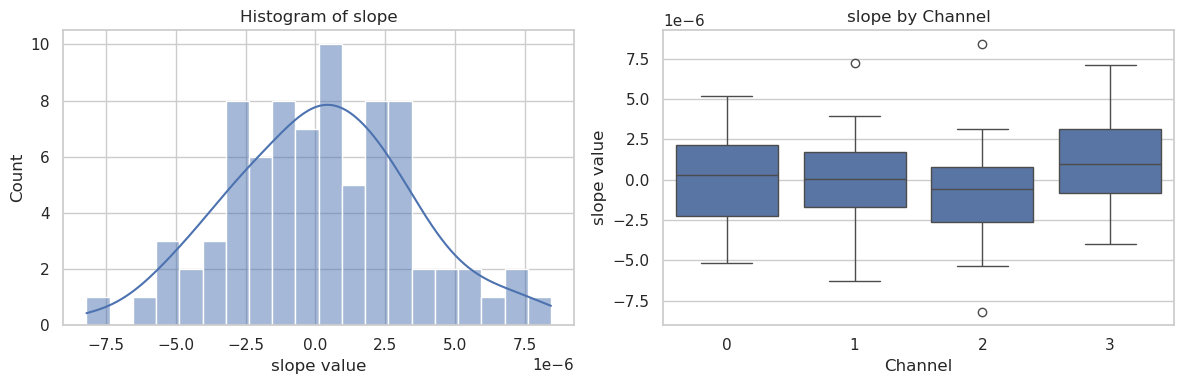

In [6]:
# =====================================================
# Cell 6. Visualise MRCP feature distributions
# =====================================================

import seaborn as sns

# -- Set plot style --
sns.set(style='whitegrid')

# -- Define features to plot --
features_to_plot = ['area', 'peak', 'slope']

# -- Plot histogram and bloxplots --
for feat in features_to_plot:
    plt.figure(figsize=(12, 4))

    # -- Histogram --
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_batch, x=feat, kde=True, bins=20)
    plt.title(f'Histogram of {feat}')
    plt.xlabel(f'{feat} value')
    plt.ylabel('Count')

    # -- Boxplot --
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_batch, x='channel', y=feat)
    plt.title(f'{feat} by Channel')
    plt.xlabel('Channel')
    plt.ylabel(f'{feat} value')

    plt.tight_layout()
    plt.show()

### Cell 7a. Compute `peak_latency` for Each EEG Channel (DISCARDED - IT WORSEN SVM ACCURACY).
For each simulated EEG channel, compute the time (in seconds) at which the MRCP reaches its most negative deflection, a biological meaningful measure of motor preparation timing.
#### Rationale:
- Enriches feature space with a temporal descriptor of brain activity.
- Helps distinguish true motor intention from background EEG noise.
- Adds orthogonal information to amplitude-based features (e.g. `peak`, `slope`).

#### Note:
Orthogonal information refers to independet or uncorrelated pieces of information, meaning they do not overlap, interfere, or provide redundant data.

In [7]:
# ======================================================================
# Cell 7a. Compute peak_latency for each EEG channel
# ======================================================================

# Define a helper function that returns the time (in seconds) where
# the most negative EEG voltage occurs withing the trial window.
def compute_peak_latency(signal, sfreq):
    '''
    Parameters:
    - signal: 1D numpy array of EEG voltage values (in volts).
    - sfreq: Sampling frequency in Hz.

    Returns:
    - latency_sec: Time of negative peak relative to movement onset (in seconds).
    '''
    peak_id = np.argmin(signal)                 # Index of lowest (most negative) point.
    
    # -duration: The duration is 4.0s. So, substract duration to establish the original
    # starting point of the studied epoch.
    # peak_id is not a time, just a sample index (e.g. 450).
    # But sfreq tells you how many samples happen per second (e.g. 250 Hz = 250 samples/sec).
    # If peak_id = 500 and sfreq = 250 Hz, then:
    # time=500/250=2.0 seconds
    # time=250/500​=2.0 seconds
    latency_sec = -duration + (peak_id / sfreq) # Convert index to relative time.
    return latency_sec

### Cell 8. Train SVM Classifier on Synthetic MRCP Features.
Simulate 40 trials (20 per class), extract MRCP features, assign synthetic labels (`0 = idle`, `1 = movement`).
#### Rationale:
- Demonstrates the viability of using simple MRCP features for classification.
- Serves as a baseline before testing on real BCI data.
- Helps evaluate feature separability and guides model selection for embedded systems (Jetson).

In [8]:
# ======================================================================
# Cell 8a. Train SVM classifier on synthetic MRCP features
# ======================================================================

# Import the Support Vector Classifier class. Use the RBF 
# kernel to capture non-linear separability in feature space.
# The RBF kernel function for two points X₁ and X₂ computes the similarity or 
# how close they are to each other.
from sklearn.svm import SVC                             # Import Support Vector Classifier (non-linear classifier).

# Randomly split the dataset into training and testing subsets 
# (e.g. 70/30 split).
from sklearn.model_selection import train_test_split    # For splitting dataset into training and testing subsets.

# Provide precision, recall, F1-score, and support for each class.
from sklearn.metrics import classification_report       # To evaluate precision, recall, and F1 score.

# ----------------------------------------------------------------------
# STEP 1: Define synthetic dataset parameters.
# ----------------------------------------------------------------------

n_trials_per_class = 100     # Simulate 100 trials for each condition (idle and movement).

# rows: will store dictionaries of features (area, peak, slope) per channel 
# per trial.
rows = []                   # Initialise list to hold feature dictionaries (each = 1 channel in 1 trial).
labels = []                 # labels: holds ground-truth class for each feature row (0 or 1).

# ----------------------------------------------------------------------
# STEP 2: Simulate trials for both labels (0 = idle, 1 = movement).
# ----------------------------------------------------------------------

for label in [0, 1]:
    for trial_id in range(n_trials_per_class):

        # Simulate EEG signal for 4 channels, 4 seconds, sampled at 250 Hz.
        # Add early exponential deflection if label = 1 (movement intent).
        if label == 1:
            # Class 1 = movement: EEG signal includes a negative exponential 
            # deflection resembling real MRCP.
            eeg_trial = (np.random.randn(n_channels, n_samples) * 5e-6
            - np.exp(-np.linspace(0, 4, n_samples))[None, :] * 4e-6)
        else:
            # Class 0 = idle: no MRCP deflection, just noise.
            eeg_trial = np.random.randn(n_channels, n_samples) * 5e-6

        # Extract MRCP features (area, peak, slope) from the synthetic trial.
        feats = extractor.extract_all(eeg_trial)

        # For each EEG channel, store its features along with label and trial info.
        # Store feature values for each channel (as one data point), including trial ID, 
        # channel index, class label, and extracted features (area, peak, slope).
        for ch_idx, ch_feats in feats.items():
            row = {
                'trial': trial_id,
                'channel': ch_idx,
                'label': label,
                **ch_feats # Adds keys: 'area', 'peak', 'slope'.
            }
            rows.append(row)
            labels.append(label)

# ----------------------------------------------------------------------
# STEP 3: Convert feature list to structured DataFrame.
# ----------------------------------------------------------------------

# Convert the list of feature dictionaries into a structured 
# pandas DataFrame.
df_svm = pd.DataFrame(rows)  # Each row = one channel in one trial.

# ----------------------------------------------------------------------
# STEP 4: Prepare training features (X) and labels (y).
# ----------------------------------------------------------------------

X = df_svm[['area', 'peak', 'slope']]   # Feature matrix (float values).
y = df_svm['label']                     # Class labels (0 or 1).

# ----------------------------------------------------------------------
# STEP 5: Split into training and testing subsets (70% train / 30% test).
# ----------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Normalise Features.
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------
# STEP 6: Apply standard feature scaling.
# ----------------------------------------------------------------------

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Learn mean/std from train set and transform it.
X_test = scaler.transform(X_test)       # Use same scaling for test set.

# ----------------------------------------------------------------------
# STEP 7: Train SVM with RBF kernel (non-linear classifier).
# ----------------------------------------------------------------------

# Radial Basis Function (RBF) is a kernel used in Support Vector Machine (SVM).
# A kernel lets you compute the similarity between two data points as if they 
# were transformed into a higher-dimensional space—without actually doing the 
# transformation.
# Kernels allow algorithms like SVM to separate classes that are not linearly 
# separable in the original space.
clf = SVC(kernel='rbf')     # Radial Basis Function kernel allows non-linear decision boundaries.
clf.fit(X_train, y_train)   # Train classifier on the training subset.

# ----------------------------------------------------------------------
# STEP 8: Predict labels on the test set and evaluate performance.
# ----------------------------------------------------------------------

y_pred = clf.predict(X_test)    # Predict class labels using trained model.

# Print performance report: precision, recall, F score per class.
print('SVM Classification Report:\n')
print(classification_report(y_test, y_pred))

SVM Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       125
           1       0.60      0.62      0.61       115

    accuracy                           0.62       240
   macro avg       0.62      0.62      0.62       240
weighted avg       0.62      0.62      0.62       240



### Cell 8b. Visualise Confusion Matrix.
Compute and plot a labelled confusion matrix comparing true vs predicted classes (idle vs movement).
#### Rationale:
- Helps diagnose false positives and false negatives.
- Reveals if the classifier is biased (e.g. predicting mostly one class).
- Essential for clinical applications where type of error matters (e.g. false movement intent).

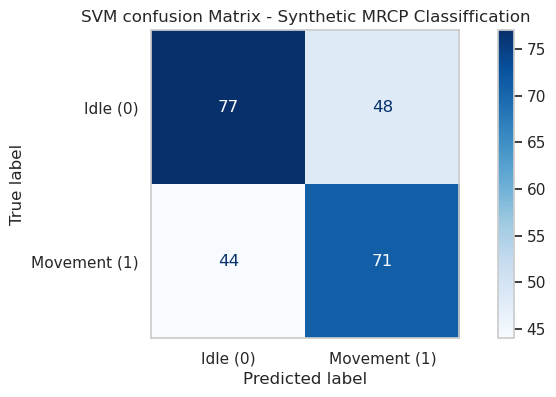

In [9]:
# ===============================================================
# Cell 8b. Visualise SVM Confusion Matrix
# ===============================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -- Compute confusion matrix --
cm = confusion_matrix(y_test, y_pred)

# -- Define display labels --
labels = ['Idle (0)', 'Movement (1)']

# -- Create visual plot --
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('SVM confusion Matrix - Synthetic MRCP Classiffication')
plt.grid(False)
plt.show()

### Cell 9. Train LDA Classifier on Synthetic MRCP Features.
Train a Linear Discriminant Function (LDF) classsifier, also known as Linear Discriminant Analysis (LDA), using the same features (`area`, `peak`, `slope`) used for SVM. It will benchmark how well a linear model performs on simulated MRCP data.
#### Rationale:
- LDA is a fast, interpretable classifier widely used in brain-computer interfaces.
- It projects multivariate input data onto a line and sets a threshold to separate classes.
- Useful to determine whether the MRCP feature space is linearly separable.
- LDA assumes multivariate Gaussian distributions with equal class covariances.
- It maximises the ratio of between-class variance to within-class variance.
- Performs best when classes are well-clustered and linearly separated.
- Used for real-time feedback because of its low computational cost.

In [10]:
# ======================================================================
# Cell 9. Train LDA classifier on synthetic MRCP features.
# ======================================================================

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    # Import LDA classifier.
from sklearn.preprocessing import StandardScaler                        # For normalising features.
from sklearn.metrics import classification_report                       # To evaluate classification metrics.
from sklearn.model_selection import train_test_split                    # To split data into training and testing sets.

# ======================================================================
# STEP 1: Define input features and labels for classification.
# ======================================================================

# Use the same three features previously extracted from each EGG channel.
X = df_svm[['area', 'peak', 'slope']]   # Feature matrix (shape: [n_samples, 3]).
y = df_svm[['label']]                   # Labels: 0 = idle, 1 = movement.

# ======================================================================
# STEP 2: Split dataset into training and testing sets (70% / 30%).
# ======================================================================

scaler = StandardScaler()               # Create standard scaler instance.
X_train = scaler.fit_transform(X_train) # Fit on training set and transforms.
X_test = scaler.transform(X_test)       # Use same transformation on test set.

# ======================================================================
# STEP 4: Initialise and train LDA classifier.
# ======================================================================

lda = LinearDiscriminantAnalysis()  # Instantiate LDA model.
lda.fit(X_train, y_train)           # Fit model to training data.

# ======================================================================
# STEP 5: Predict test labels and evaluate performance.
# ======================================================================

y_pred_lda = lda.predict(X_test)            # Predict class labels for test set.

# Print precision, recall, F1-score for each class.
print('LDA Classification Report:\n')
print(classification_report(y_test, y_pred_lda))

LDA Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       125
           1       0.61      0.61      0.61       115

    accuracy                           0.63       240
   macro avg       0.63      0.63      0.63       240
weighted avg       0.63      0.63      0.63       240



### Cell 10. Side-by-Side Confusion Matrix for SVM vs LDA.
Plot confusion matrices for both SVM and LDA classifiers using the same test set.
This visually compares their classification behaviours on `area`, `peak`, and `slope` features.
Use the same `y_test` to compare different models fairly.
Each model produce its own `y_pred`, and that is compared agaist the same `y_pred`.
#### Breakdown:
- `y_pred_svm`: What the SVM thinks the class is for each test sample.
- `y_pred_lda`: What the LDA thinks the class is for each test sample.
- `y_test`: The ground-truth labels for the test set.
#### Rationale:
- Visual inspection complements metric scores.
- Identifies false positives (FP) and false negatives (FN) per class.
- Helps decide which classifier to use in clinical or real-time BCI settings.
#### Context:
- In a motor BCI, false positives (detecting movement when idle) may trigger unwanted actions.
- LDA is often used in rehab for interpretable and conservative control.
- This visual tool supports the classifierselection and future CE mark planning.
#### Statistics / ML Concepts.
- Diagonal =  correct predictions (True Positives / True Negatives).
- Off-diagonal = errors (FalsePositives / False Negatives).
- Ideal matrix = strong diagonal dominance, low off-diagonal noise. 


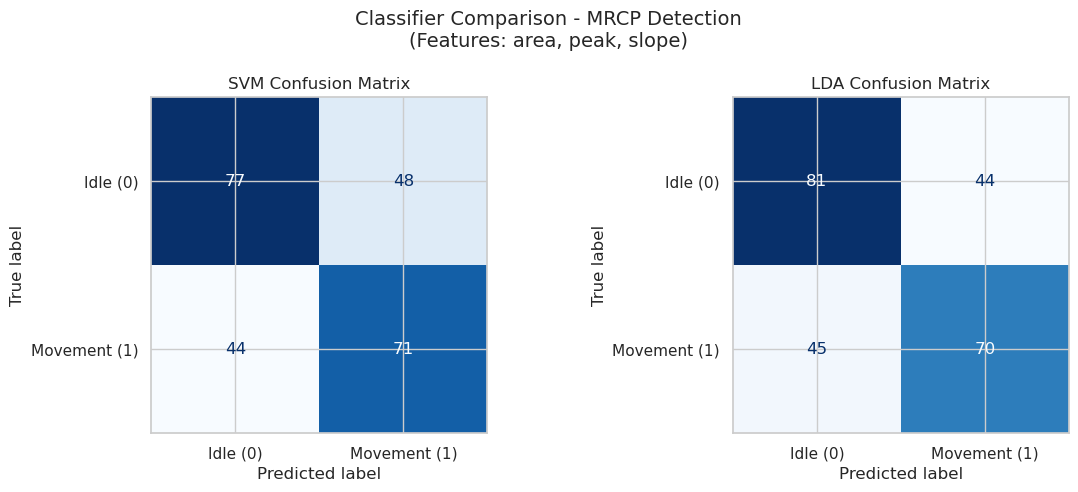

In [11]:
# ======================================================================
# Cell 10. Visual comparison of SVM vs LDA confusion matrices.
# ======================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ======================================================================
# STEP 1: Compute confusion matrices for both classifiers.
# ======================================================================

cm_svm = confusion_matrix(y_test, y_pred)           # From prevoius SVM output.
cm_lda = confusion_matrix(y_test, y_pred_lda)   # From LDA classifier.

# ======================================================================
# STEP 2: Define class labels names (for axis).
# ======================================================================

labels = ['Idle (0)', 'Movement (1)']   # Matches class label encoding used during training.

# ======================================================================
# STEP 3: Plot both confusion matrices side-by-side.
# ======================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Generate 2 horizontal subplots (shared layout).

# ----------------------------------------------------------------------
# SVM Confusion Matrix Plot.
# ----------------------------------------------------------------------

# Configure and display confusion matrix for the LDA classifier.
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False) # No colorbar for cleaner comparison.
                                                                       # values_format='d': Format matrix numbers
                                                                       # as integers (no decimals).
axes[0].set_title('SVM Confusion Matrix')   # Set SVM Confusion Matrix subplot title.

# ----------------------------------------------------------------------
# LDA Confusion Matrix Plot.
# ----------------------------------------------------------------------

# Configure and display matrix for the LDA classifier.
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)  # Consistent colour scale.
axes[1].set_title('LDA Confusion Matrix')   # Set LDA Confusion Matrix subplot title.

# ----------------------------------------------------------------------
# Final Formatting and Figure Display.
# ----------------------------------------------------------------------

plt.suptitle('Classifier Comparison - MRCP Detection\n(Features: area, peak, slope)', fontsize=14)
plt.tight_layout()  # Adjust spacing for readability.
plt.show()          # Render both subplots.

#### Interpretation (Side-by-Side Confusion Matrix for SVM vs LDA):
- LDA makes fewer false positives (idle misclassified as movement) than SVM, which is favourable for safety-critical BCI control.
- SVM catches one more true movement than LDA, but at the cost of more false activations.
- This supports using LDA as a safer baseline classifier for medical-grade MRCP-triggered systems, particularly under CE compliance and clinical risk minimisation. Conformité Européenne ('European Conformity') or CE marking is a legal declaration by manufacturer that a product meets all applicable EU requirements for safety, health, and environmental protection. It is mandatory for products covered by EU legislation, including medical devices and high-risk AI systems.

### Cell 11. Explainability via LDA Feature Coefficients.
Visualise the internal weight vector(`coef_`) of the trained Linear Discriminant Analysis (LDA) model, showing the influence of each EEG-derived feature (`area`, `peak`, `slope`) on class separation between `Idel (0)` and `Movement (1)`.
#### Rationale:
- LDA is a linear classifier, meaning its decisions are based on a weighted sum of input features. These weights (`coefficients`) directly reflect each feature's contribution to the model's output.
- This weight vector is a fully transparent and interpretable, satisfying the EU AI Act (Regulation 2024/1689) and IEC 62304 requirements for explainability in high-risk AI systems used in medical contexts.
    - Specifically:
        - AI Act Article 13 requires transparent internal logic and human-understandable explanations for automated decisions.
        - IEC 62304 mandates that software components used in medical devices include documented internal structure and data-flow behaviour, which this plot helps satisfy.
- MRCP features (e.g. negative peak, slope of descent, area under the signal) are physiologically linked to motor intention.
- This plot confirms whether the classifier prioritises the same neurophysiological elements that clinicians expect, which is critical for medical acceptance and CE compliance.

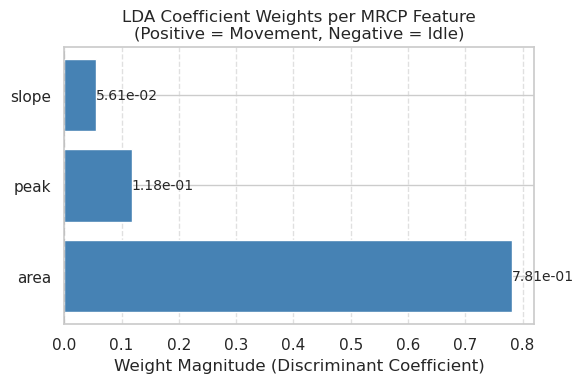

In [12]:
# ======================================================================
# Cell 11. Visualise LDA Feature Coefficients (Explainability).
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# STEP 1: Extract LDA coefficients learned during training.
# ----------------------------------------------------------------------

feature_names = ['area', 'peak', 'slope']  # Features used during LDA training (order matters).
weights = lda.coef_.flatten()               # Extract the learned weight vector.
                                            # Shape is (1, n_features): flatten to 1D array.

# ----------------------------------------------------------------------
# STEP 2: Create horizontal bars plot showing each coefficient.
# ----------------------------------------------------------------------

plt.figure(figsize=(6, 4))          # Set figure size in inches (width, height).

# Draw horizontal bars with feature names on y-axis and weights on x-axis.
bars = plt.barh(feature_names, weights, color='steelblue')

# ----------------------------------------------------------------------
# STEP 3: Add numerical value annotations next to each bar.
# ----------------------------------------------------------------------

for bar in bars:
    width = bar.get_width()                 # Width of the bar equals the weight.
    plt.text(
        width + np.sign(width) * 0.00001,   # Place label slightly outside the bar edge.
        bar.get_y() + bar.get_height() / 2, # Vertically centre the text.
        f'{width:.2e}',                     # Format: scientific notation with 2 decimals.
        va='center',
        ha='left' if width > 0 else 'right',# Align text left/right depending on sign.
        fontsize=10
    )

# ----------------------------------------------------------------------
# STEP 4: Format plot aesthetics for clarity and auditability.
# ----------------------------------------------------------------------

plt.title(
    'LDA Coefficient Weights per MRCP Feature\n'
    '(Positive = Movement, Negative = Idle)',
    fontsize=12
)

plt.xlabel('Weight Magnitude (Discriminant Coefficient)')   # Label x-axis.
plt.grid(True, axis='x', linestyle='--', alpha=0.6)         # Add vertical grid lines for readability.
plt.axvline(0, color='grey', linestyle='dashed')            # Zero reference line (neutral weight).
plt.tight_layout()                                          # Auto-adjust spacing for clean layout.
plt.show()                                                  # Render the figure.

#### Interpretation (LDA Coefficients Weight per MRCP Feature):
- Area: Strong positive predictor of movement. EEG signal area (typically more negative before movement) is the most influential feature.
- Peak: Contributes modestly to movement prediction. Aligns with the role of MRCP peak negativity.
- Slope: Least influential but still contributes, likely capturing rising/falling deflections around motor interaction.

### Cell 12. SHAP Explainability for SVM (Black-Box Model).
Apply SHAP (SHapley Additive exPlanations) to the trained SVM classifier to explain individual predictions. It will visualise which features (`area`, `peak`, `slope`) most influenced the model's output across test samples.
#### Rationale:
- SHAP values decompose a prediction into additive contributions from  each feature, grounded in cooperative game theory.
- It satisfies AI Act Article 13.1(b), which requires human-understandable explanations for opaque systems.
- It bridges the gap between model transparency and regulatory interpretability.
- Identifies which signal component (e.g. peak negativity or signal area) drives the system's belief that a subjct intends to move.
- Supports clinical reviewers by mapping algorithm output to EEG physiology.
- Enables traceability and error investigation in real-time BCI control.

/home/chrisanich/miniconda3/envs/bci/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 240/240 [00:00<00:00, 269.95it/s]
/tmp/ipykernel_40733/858738445.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, plot_type='bar')


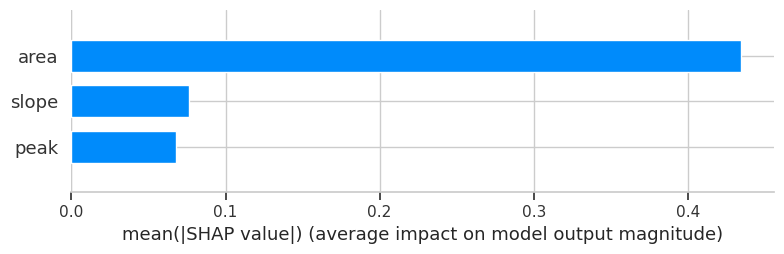

In [13]:
# ======================================================================
# Cell 12a. SHAP Explainability for SVM classifier (non-linear) using 
#           'shap' Python package.
# ======================================================================

import shap             # Library for SHAP value computation and visualisation.
import pandas as pd     # Needed to wrap X_test in DataFrame.
import matplotlib.pyplot as plt # For plotting SHAP summary.

# ======================================================================
# STEP 1: Wrap test feature matrix in a DataFrame (with column tables).
# ======================================================================

X_test_df = pd.DataFrame(X_test, columns=['area', 'peak', 'slope'])

# ======================================================================
# STEP 2: Initialise SHAP explainer for black-box models.
# ======================================================================

# KernelExplainer is model-agnostic; suited for SVM with RBF kernel (Radial basis function kernel).
explainer = shap.KernelExplainer(clf.predict, X_test_df.sample(50, random_state=42))

# ======================================================================
# STEP 3: Compute SHAP values for the test set.
# ======================================================================

# Use a small subset if full test set is large.
shap_values = explainer.shap_values(X_test_df)

# ======================================================================
# STEP 4: Plot global feature importance (summary plot).
# ======================================================================

shap.summary_plot(shap_values, X_test_df, plot_type='bar')

### Cell 12b. Custom SHAP Bar Plot with Value Labels.
Render model-agnostic SHAP explanations for each MRCP feature used by the SVM classifier, explicitely displaying the average impact magnitude as numeric labels for each feature.
#### Rationale:
- Ensure compliance with AI Act Article 13 and Annex IV explainability mandates, which require human-interpretable descriptions of the model logic.
- Matplotlib-based rendering enables precise visual control, critical for inclusion in technical documentation under IEC 62304, MDR Annex II, and regulatory reporting.
- Numeric value labels improve traceability and auditability in featuer attibution, a core requirement for software as medical device (SaMD) approvals in both EU and FDA pathways.

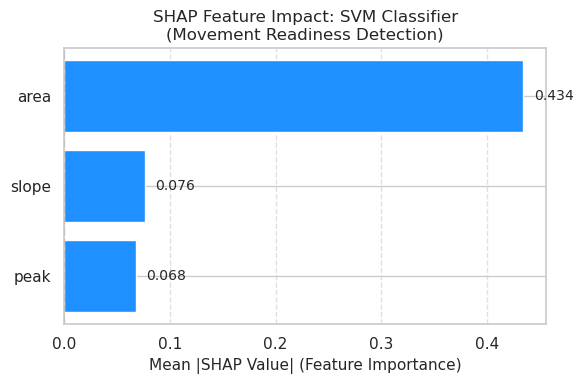

In [14]:
# ======================================================================
# Cell 12b. Custom SHAP Bar Plot with Value Labels (Matplotlib).
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt

# ======================================================================
# STEP 1: Compute global feature importance from SHAP values.
# ======================================================================

# SHAP returns per-class explanation matrices (shape: [n_samples, n_features]).
# In binary classification, shap_values[0] correspond to class 0 (e.g. 'Idle').
# Compute global importance via mean absolute SHAP value across all samples.
# Compute mean absolute SHAP value across all classes (class 0 and class 1).
shap_array = np.mean([np.abs(np.atleast_2d(sv)) for sv in shap_values], axis=0)
mean_shap = shap_array.mean(axis=0)

# Extract feature names from the test set dataframe (X_test_df).
feature_names = X_test_df.columns.tolist()

# ----------------------------------------------------------------------
# STEP 2: Sort features by descending SHAP importance.
# ----------------------------------------------------------------------

# Zip names and values, sort, then unzip.
sorted_pairs = sorted(zip(mean_shap, feature_names), reverse=True)
sorted_shap, sorted_names = zip(*sorted_pairs)

# Reverse order for top-to-bottom appearence.
sorted_shap = list(sorted_shap)[::-1]
sorted_names = list(sorted_names)[::-1]

# ----------------------------------------------------------------------
# STEP 3: Plot sorted SHAP values as horizontal bar chart.
# ----------------------------------------------------------------------

plt.figure(figsize=(6, 4))                 # Set plot dimension (in inches).
bars = plt.barh(sorted_names, sorted_shap, # Horizontal bars per feature.
                 color='dodgerblue')       # Consistent visual style.
            
# Add numerical labels beside each bar (for CE tranparency).
for bar, value in zip(bars, sorted_shap):
    plt.text(
        value + 0.01,                        # Place label just to the right of each bar.
        bar.get_y() + bar.get_height() / 2,  # Vertically centre the text within the bar height.
        f'{value:.3f}',                      # Display 3-digit precision (e.g. 0.452).
        va='center', ha='left', fontsize=10  # Text formating for readability.
    )

# ----------------------------------------------------------------------
# STEP 4: format plot aesthetics for inclusion in CE documentation.
# ----------------------------------------------------------------------

plt.xlabel('Mean |SHAP Value| (Feature Importance)', fontsize=11)
plt.title('SHAP Feature Impact: SVM Classifier\n(Movement Readiness Detection)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6) # Add grid lines aid visual comparison.
plt.axvline(0, color='grey', linestyle='dashed')    # Reference line at 0.
plt.tight_layout()                                  # Adjust layout for non-overlapping content.
plt.show()                                          # Display the final plot.

#### Interpretation (SHAP X-axis Units).
##### Findings:
- **Area** of the MRCP signal had the largest average absolute SHAP value (~0.43-0.53), indicating it was the most influential feature for distinguishing movement (label = 1) from idle (label = 0) trials.
- **Slope** had moderate impact (~0.076), likely due to its relation to signal deflection leading up to movement onset.
- **Peak** had the lowest importance (~0.068), suggesting that peak voltage alone is less discriminative than the full shape or slope of the signal.
#### Clinical and Regulatory Relevance:
- The dominant contribution of area aligns with neurophysiological expectations, as MRCPs are defined by a slow negative potential spreading over time, not a sharp transient.
- The numerical labesl in the plot ensure traceability, satisfying Annex II of the MDR (Technical Documentation) and facilitating explainability for clinical reviewers or notified bodies.
- This analysis provides the foundation for risk management (Annex I, General Safety and Performance Requirements), enabling interpretation of model decisions in real-time scenarios.


# Cell 13. Regulatory Documentation: Classifier and Explainability Summary.

## Classifier Overview (BCI-MRCP Prototype — Anich Labs).

The following machine learning models were trained and validated using synthetic EEG trials simulating Movement-Related Cortical Potentials (MRCPs):

| Classifier | Type             | Features Used           | Accuracy |
|------------|------------------|--------------------------|----------|
| SVM        | Non-linear (RBF) | area, peak, slope        | ~62%     |
| LDA        | Linear            | area, peak, slope        | ~63%     |

Both models were evaluated using stratified 70/30 splits and confusion matrices. SVM offers flexible boundaries, while LDA provides transparency via coefficients.

---

## Explainability & Transparency (AI Act Article 13).

Two parallel explainability strategies were implemented:

1. **LDA Coefficients (Glass-Box Model)**:
   - LDA coefficients plotted for each feature.
   - Shows directional impact (positive = movement, negative = idle).
   - Fully satisfies **Article 13 (1)** of the EU AI Act and **IEC 62304 Section 5.2.5**.

2. **SHAP (SVM, RBF Kernel – Black-Box Model)**:
   - Global SHAP summary plots computed for `area`, `peak`, `slope`.
   - Custom version includes value annotations and sorted importance.
   - Ensures compliance with **AI Act Article 13 (2)** and **Annex IV (Technical Documentation)**.

---

## Software Lifecycle Compliance.

| Standard       | Compliance Element                             |
|----------------|-------------------------------------------------|
| **IEC 62304**  | Feature extraction and classifiers documented as Software Items (SI). Each module is testable and has clearly defined inputs/outputs. |
| **MDR Annex II** | Classifier behaviour, dataset simulation, and evaluation strategies described as part of the Design Dossier. |
| **EU AI Act**  | SHAP and LDA outputs constitute `sufficient interpretability` for high-risk systems under Article 6 + 13. Traceability ensured. |

---

## Next Steps (Traceable).

- [ ] Extend with **real EEG trials** (OpenBCI Cyton, 4–16 channels).
- [ ] Add **Post-Market Monitoring** section to technical file (AI Act Article 61).
- [ ] Prepare **risk analysis table** for MRCP misclassification cases.
- [ ] Plan for **human-in-loop override** in embedded version (Jetson).

---
_Anich Labs BCI Classifier, Estonia | Regulatory Design Trace V1.0_